Generates a high-resolution PDF figure according to the method from [Donchyts et.al., 2016](http://www.mdpi.com/2072-4292/8/5/386)

In [1]:
%matplotlib inline

import urllib, io, os

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import seaborn as sns

from skimage import filters

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from shapely.geometry import mapping, shape

from IPython.display import Image, display

import ee

In [2]:
ee.Initialize()

In [5]:
# define location (Dubai)
geometry = ee.Geometry.Polygon(
        [[[54.94803425942996, 24.96652872736307],
          [55.033264838241735, 24.968551791222385],
          [55.03223484885575, 25.040348953381287],
          [54.94803425837563, 25.039649067823706]]])
        
start = '2014-03-15'
stop = '2014-03-16'

removeShortEdges = False 

canny_sigma = 1
canny_threshold = 0.4

water_bands = ['B3', 'B6']

vis = {'bands':['B6', 'B5', 'B3'], 'min':0.05, 'max': 0.5}

In [6]:
geometry = geometry.buffer(240).bounds()

In [62]:
# generate percentile composite image
images = ee.ImageCollection("LANDSAT/LC8_L1T_TOA")
images = images.filterBounds(geometry)
images = images.filterDate(start, stop)
image = images.toList(1,0).get(0)
    
image = ee.Image(image)

In [63]:
bounds = shape(geometry.bounds().getInfo())
coords = list(bounds.boundary.coords)

xmin = coords[0][0]
xmax = coords[1][0]
ymin = coords[0][1]
ymax = coords[2][1]

extent = (xmin, xmax, ymin, ymax)

In [64]:
print(extent)

(54.94565049259565, 55.03564702417423, 24.96436900117639, 25.04250859637973)


In [65]:
def get_path(image):
    return image.getThumbURL({'region' : geometry.getInfo(), 'format': 'png', 'dimensions': 1024})

def download(image, path_out):
    path = get_path(image)
    
    if os.path.exists(path_out):
            os.remove(path_out)
    
    urllib.request.urlretrieve(path, path_out)

def show(path_out):
    plt.grid(False)
    plt.imshow(plt.imread(path_out))

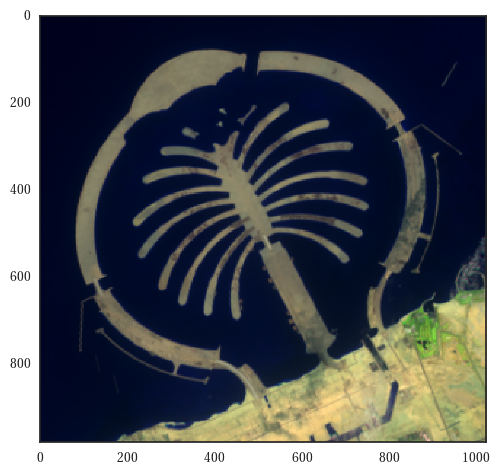

In [66]:
im = image.visualize(**vis)

path = 'step1_image_swir1_nir_green.png'
download(im, path)
show(path)


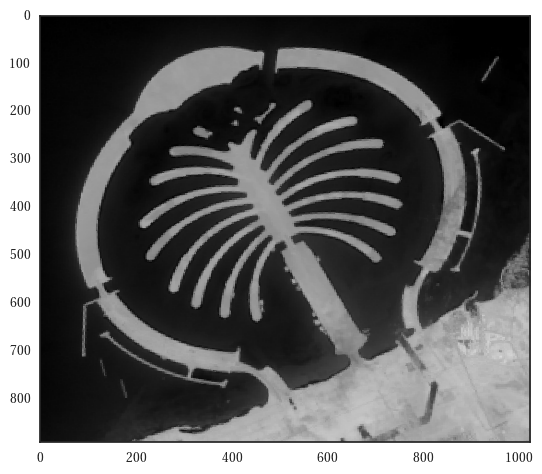

In [67]:
ndwi = image.normalizedDifference(water_bands)    

im = ee.ImageCollection.fromImages([
        ndwi.visualize(**{'min':-0.5, 'max':0.5, 'palette':['ffffff', '000000']})
    ]).mosaic()

path = 'step2_ndwi.png'
download(im, path)
show(path)

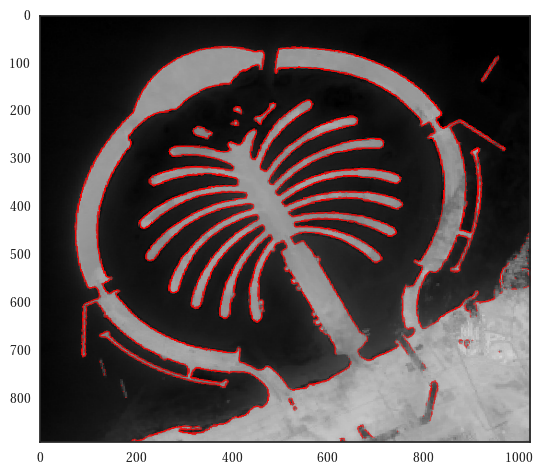

In [68]:
edge = ee.Algorithms.CannyEdgeDetector(ndwi, canny_threshold, canny_sigma)

# remove short edges
if removeShortEdges:
    connected = edge.mask(edge).lt(0.8).connectedPixelCount(35, True)
    edgeLong = connected.gte(35)
    edge = edgeLong

im = ee.ImageCollection.fromImages([
        ndwi.visualize(**{'min':-0.5, 'max':0.5, 'palette':['ffffff', '000000']}),
        edge.focal_max(1).mask(edge.focal_max(1)).visualize(**{'palette':['ff0000']})
    ]).mosaic()

path = 'step3_ndwi_edges.png'
download(im, path)
show(path)

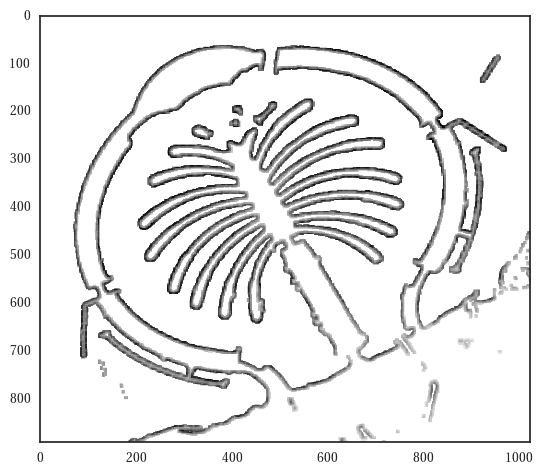

In [70]:
ndwi_buffer = ndwi.mask(edge.focal_max(30, 'square', 'meters'))

im = ee.ImageCollection.fromImages([
        ee.Image(1).visualize(**{'palette':['ffffff']}),
        ndwi_buffer.visualize(**{'min':-0.5, 'max':0.5, 'palette':['ffffff', '000000']}),
    ]).mosaic()

path = 'step4_ndwi_buffer.png'
download(im, path)
show(path)

0.154478730938


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(-1, 1)

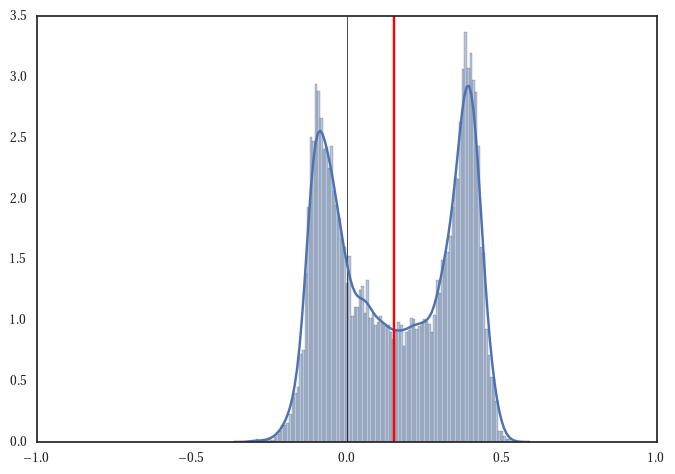

In [71]:
# local threshold

ndwi_buffer = ndwi.mask(edge.focal_max(30, 'square', 'meters'))

hist = ndwi_buffer.reduceRegion(ee.Reducer.histogram(150), geometry, 30).getInfo()

values = ndwi_buffer.reduceRegion(ee.Reducer.toList(), geometry, 15).getInfo()

th = filters.threshold_otsu(np.array(values['nd']))
print(th)

sns.set_style('white')
f = plt.figure()
plt.plot([0, 0], [0, 3.5], 'k-', lw=0.5)
sns.distplot(values['nd'], bins=100, kde_kws={'bw': 0.02})
plt.plot([th, th], [0, 3.5], 'r-')
plt.xlim(-1, 1)

In [72]:
# detect water
water = ndwi.gt(th)
water_edge = ee.Algorithms.CannyEdgeDetector(water, 0.5, 0)

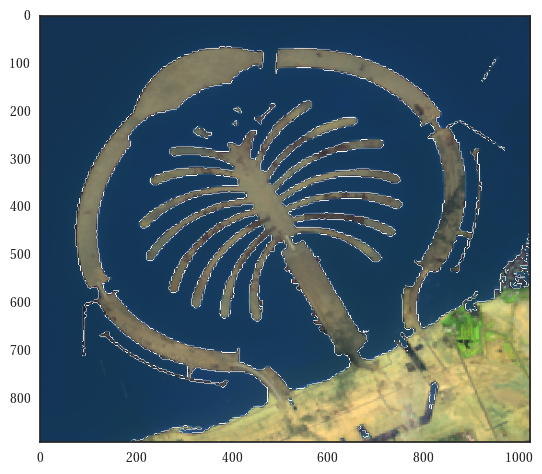

In [74]:
im = ee.ImageCollection.fromImages([
        image.visualize(**{'min':0.05, 'max':0.5, 'bands': ['B6', 'B5', 'B3']}),
        # image.visualize(**{'min':0.03, 'max':0.5, 'bands': ['B4', 'B3', 'B2']}),
        water.mask(water).visualize(**{'opacity':0.3, 'palette':['43a2ca']}),
        water_edge.mask(water_edge).visualize(**{'palette':['ffffff']}),
        
    ]).mosaic()

path = 'step5_water_final.png'
download(im, path)
show(path)

## Figure

In [75]:
from matplotlib import rc,rcParams


params = {
    'text.usetex': True,
    'text.latex.preamble' : [
        r'\usepackage{siunitx}', r'\usepackage{amsmath}',
        # r'\usepackage[T1]{fontenc}', r'\usepackage[utf8]{inputenc}',
        r'\usepackage{lmodern}', r'\usepackage{fourier}'

        # r'\usepackage{siunitx}', r'\usepackage{amsmath}', r'\usepackage{sansmath}', '\sansmath'
    ],
    'font.family' : 'lmodern',
    'text.latex.unicode': False,
}

    
plt.rcParams.update(params)


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


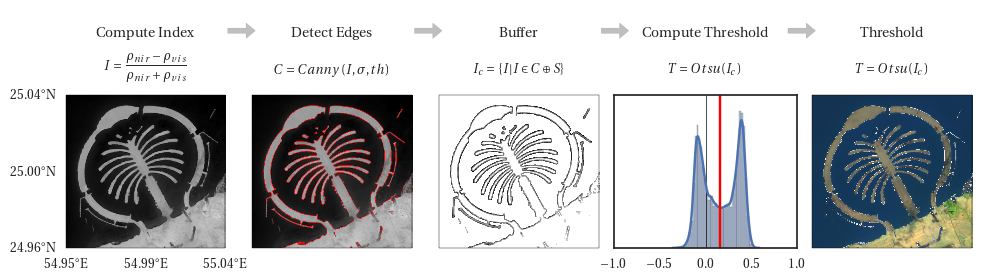

In [78]:
f = plt.figure(figsize=(12,3))
gs = gridspec.GridSpec(3, 5, height_ratios=[0.2,0.3,1] )

gs.update(wspace=0.02, hspace=0.02) # set the spacing between axes. 

    
# -------------------- row 1 (flowchart)
ax = plt.subplot(gs[0,0])
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Compute Index', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = plt.subplot(gs[0,1])
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Detect Edges', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = plt.subplot(gs[0,2])
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Buffer', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = plt.subplot(gs[0,3])
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Compute Threshold', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = plt.subplot(gs[0,4])
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Threshold', fontweight='bold', fontsize=11, horizontalalignment='center')


# ---------------------- row 2 (equations)
ax = plt.subplot(gs[1,0])
ax.set_axis_off()
ax.text(0.5, 0.5, r'$I=\dfrac{\rho_{nir}-\rho_{vis}}{\rho_{nir}+\rho_{vis}}$', fontsize=10, ha='center', va='center')

ax = plt.subplot(gs[1,1])
ax.set_axis_off()
ax.text(0.5, 0.5, r'$C=Canny\left(I,\sigma,th\right)$', fontsize=10, ha='center', va='center')

ax = plt.subplot(gs[1,2])
ax.set_axis_off()
ax.text(0.5, 0.5, r'$I_c=\left\{ I | I \in C \oplus S \right\}$', fontsize=10, ha='center', va='center')

ax = plt.subplot(gs[1,3])
ax.set_axis_off()
ax.text(0.5, 0.5, r'$T=Otsu(I_c)$', fontsize=10, ha='center', va='center')

ax = plt.subplot(gs[1,4])
ax.set_axis_off()
ax.text(0.5, 0.5, r'$T=Otsu(I_c)$', fontsize=10, ha='center', va='center')


# -------------------- row 3 (images)
ax = plt.subplot(gs[2,0], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
ax.set_xticks(np.linspace(xmin, xmax, 3), crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(ymin, ymax, 3), crs=ccrs.PlateCarree())

# label axes as degrees
lon_formatter = LongitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
ax.xaxis.set_major_formatter(lon_formatter)

lat_formatter = LatitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
ax.yaxis.set_major_formatter(lat_formatter)

# show image
img = plt.imread('step2_ndwi.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')




ax = plt.subplot(gs[2,1], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
img = plt.imread('step3_ndwi_edges.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)


ax = plt.subplot(gs[2,2], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
img = plt.imread('step4_ndwi_buffer.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)



ax = plt.subplot(gs[2,3])
ax.set_axis_off()
ax.plot([0, 0], [0, 3.5], 'k-', lw=0.5)
sns.distplot(values['nd'], kde_kws={'bw': 0.02})
ax.plot([th, th], [0, 3.5], 'r-')
ax.set_xlim(-1, 1)
ax.set_axis_on()
ax.yaxis.set_visible(False)
# ax.text(, r'$I=\dfrac{\rho_{nir}-\rho_{vis}}{\rho_{nir}+\rho_{vis}}$', fontsize=10, ha='center', va='center')


ax = plt.subplot(gs[2,4], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
img = plt.imread('step5_water_final.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)



In [79]:
# save as high-dpi image
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages(r'step6_water_detection.pdf')
pdf.savefig(figure=f, bbox_inches='tight', dpi=600)
pdf.close()
